In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rc('axes', titlesize=18)     
plt.rc('axes', labelsize=14)   
plt.rc('xtick', labelsize=13)    
plt.rc('ytick', labelsize=13)    
plt.rc('legend', fontsize=12)    
plt.rc('font', size=13) 
import seaborn as sns
sns.set_style('darkgrid')
import re
from wordcloud import WordCloud, STOPWORDS
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from bs4 import BeautifulSoup
import tensorflow as tf
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from sklearn.model_selection import train_test_split
from tensorflow.keras import optimizers
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from keras.layers import GRU

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [2]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv


## Problem Description
Twitter is an important communication channel in times of emergency and more agencies (e.g., disaster relief organizations and news agencies) are interested in programatically monitoring Twitter. The aim of this mini-project is to build machine learning model that predicts which tweets are about real disasters (1) and which are not (0). We will have access to a dataset of 10,000 tweets to solve this text classification problem using Natural Language Processing (NLP) techniques. 

NLP (Natural Language Processing) is a subfield of artificial intelligence that focuses on the interactions between computers and humans using natural language. The goal of NLP is to enable computers to understand, interpret, and even generate human language. NLP involves different techniques such as machine learning, deep learning, and statistical methods to analyze and manipulate natural language data. NLP can be used in various tasks, for example, text classification, sentiment analysis, recommendation systems, search engines, and question answering. 

## Data
The dataset was originally created by the company figure-eight and shared on their [Data For Everyone](https://www.figure-eight.com/data-for-everyone/) website. The dataset that we'll be using for this mini-project is availalbe on [Kaggle](https://www.kaggle.com/c/nlp-getting-started/overview).

In [3]:
df_train = pd.read_csv('/kaggle/input/nlp-getting-started/train.csv')
df_test = pd.read_csv('/kaggle/input/nlp-getting-started/test.csv')
df_submission = pd.read_csv('/kaggle/input/nlp-getting-started/sample_submission.csv')

### Features in the training set
- id - a unique identifier for each tweet
- text - the text of the tweet
- location - the location the tweet was sent from (may be blank)
- keyword - a particular keyword from the tweet (may be blank)
- target - in train.csv only, this denotes whether a tweet is about a real disaster (1) or not (0)

In [4]:
df_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [5]:
print(f'The size of the training dataframe: {df_train.size}.')
print(f'{df_train.shape[0]} rows in the training dataframe.')
print(f'{df_train.shape[1]} columns in the training dataframe.')

The size of the training dataframe: 38065.
7613 rows in the training dataframe.
5 columns in the training dataframe.


In [6]:
df_test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [7]:
print(f'The size of the test dataframe: {df_test.size}.')
print(f'{df_test.shape[0]} rows in the test dataframe.')
print(f'{df_test.shape[1]} columns in the test dataframe.')

The size of the test dataframe: 13052.
3263 rows in the test dataframe.
4 columns in the test dataframe.


In [8]:
print(f'This is the format that we would follow for submission:')
df_submission.head()

This is the format that we would follow for submission:


,id,target
0,0,0
1,2,0
2,3,0
3,9,0
4,11,0


## Exploratory Data Analysis
### Data cleaning & preprocessing

In [9]:
df_train.sample(5)

,id,keyword,location,text,target
3367,4823,evacuation,NaN,VIETNAM WAR PATCH US 71st EVACUATION HOSPITAL ...,1
1607,2319,collapse,"Sugarhouse, UT",@Marvel @DCComics @ImageComics @DarkHorseComic...,0
5007,7141,military,highlands&slands scotland,Bad News for US: China Russia Bolstering Milit...,0
5182,7395,obliterated,satan's colon,@horiikawa i played online last night and got ...,0
2282,3276,demolish,Hooters on Peachtree,NOTHING YOU MIDGET I WILL DEMOLISH YOU SHOW SO...,0


Since `id` will not be used for further analysis, we'll drop it. 

In [10]:
df_train = df_train.drop(columns=['id'])

Let's check for missing values.

In [11]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   keyword   7552 non-null   object
 1   location  5080 non-null   object
 2   text      7613 non-null   object
 3   target    7613 non-null   int64 
dtypes: int64(1), object(3)
memory usage: 238.0+ KB


In [12]:
df_train.isnull().sum() / len(df_train)*100

keyword      0.801261
location    33.272035
text         0.000000
target       0.000000
dtype: float64

We can see that `keyword` and `location` columns have 0.8% and 33.3% **missing values**, respectively. 
- `keyword`: since only less than 1% of its values are missing, we could delete the rows with null vlues in this column
- `location`: since we'll not use `location` for further analysi, we can simply drop the column

Now let's check if there are any duplicates. 

In [13]:
df_train.duplicated(subset=['text']).sum()

110

We'll drop the duplicated entries.

In [14]:
df_train = df_train.drop_duplicates(subset=['text'])

In [15]:
df_train = df_train.dropna(subset=['keyword'])
df_train = df_train.drop(columns=['location'])
df_train.sample(5)

,keyword,text,target
5495,quarantine,Reddit Will Now Quarantine Offensive Content h...,0
2866,drought,Tips so that finding the customers ego drought...,0
6260,storm,Typhoon Soudelor was captured in this incredib...,1
4671,inundation,Potential Storm Surge Flooding Map by National...,1
942,blown%20up,Things you CAN pick up from tozlet seat|: butt...,0


Each tweet in the training set has been classified as either 'disaster' (1) or 'not disaster' (0). Let's check the class distribution. 

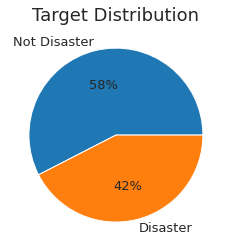

In [16]:
# check balance
plt.pie(x=df_train["target"].value_counts().values,labels=["Not Disaster", "Disaster"],autopct='%.0f%%')
plt.title("Target Distribution")
plt.show()

### Key words in tweets


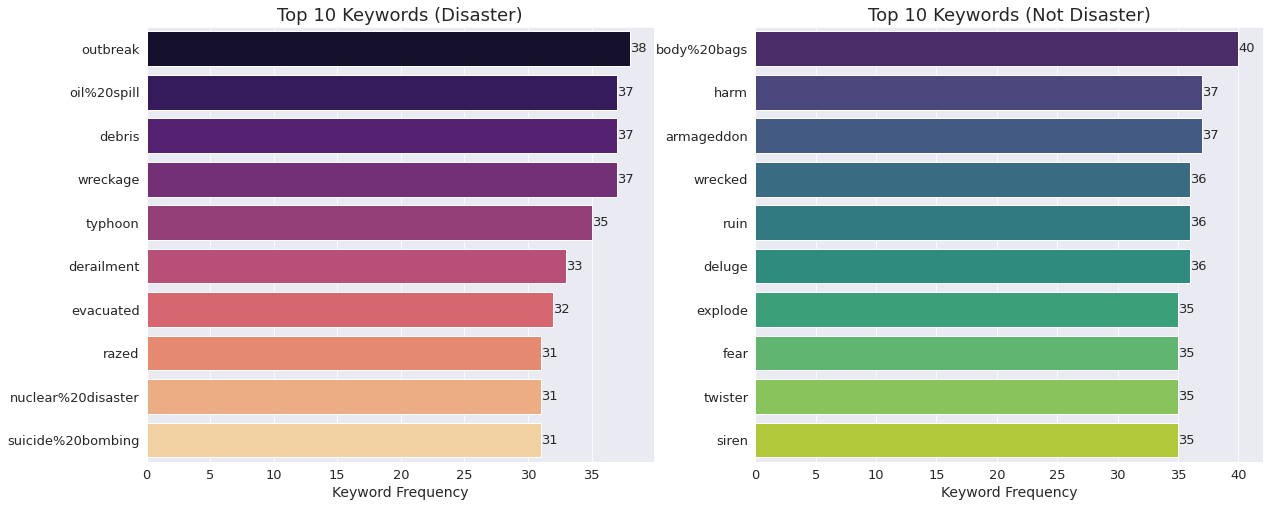

In [17]:
keywords_not_disaster = df_train.loc[df_train["target"] == 0]["keyword"].value_counts()
keywords_disaster = df_train.loc[df_train["target"] == 1]["keyword"].value_counts()

fig, ax = plt.subplots(1,2, figsize=(20,8))

ax1 = sns.barplot(y=keywords_not_disaster[0:10].index, x= keywords_not_disaster[0:10], orient='h', ax=ax[1], palette="viridis")
for container in ax1.containers:
    ax1.bar_label(container)
ax[1].set_title("Top 10 Keywords (Not Disaster)",fontsize=18)
ax[1].set_xlabel("Keyword Frequency")

ax2 = sns.barplot(y=keywords_disaster[0:10].index, x=keywords_disaster[0:10], orient='h', ax=ax[0], palette="magma")
for container in ax2.containers:
    ax2.bar_label(container)
ax[0].set_title("Top 10 Keywords (Disaster)",fontsize=18)
ax[0].set_xlabel("Keyword Frequency")

plt.show()

### Tweet world count

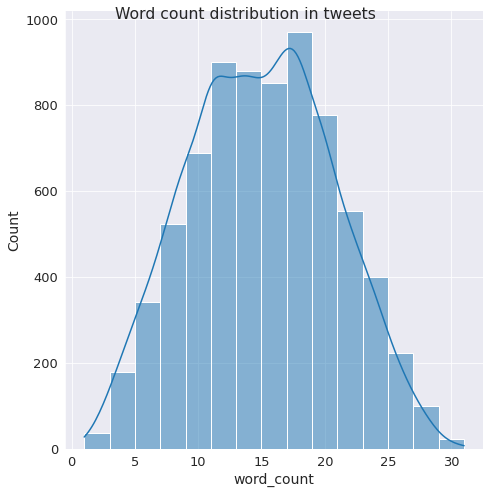

In [18]:
df_train["word_count"] = df_train["text"].apply(lambda x: len(x.split()))
ax = sns.displot(df_train["word_count"],bins=15,kde=True, height=7)
ax.fig.suptitle('Word count distribution in tweets')
plt.show()

In [19]:
df_train["word_count"].describe()

count    7447.000000
mean       14.904928
std         5.716941
min         1.000000
25%        11.000000
50%        15.000000
75%        19.000000
max        31.000000
Name: word_count, dtype: float64

On average, there are 15 words per tweet. 

Let's randomly select 10 tweets.

In [20]:
for i in df_train['text'].sample(10):
    print(i)

This is why I am scared to leave my car under trees in a storm

#jamaicaplain #boston #hailstormÛ_ https://t.co/MJ8rEZOXlJ
Experienced urogyn trying to help mesh injured women talks the worst offenders. http://t.co/NpOQLkqUP9 @meshnewsdesk
@Chemical_Babe its a family emergency so I can't make it unless I have a chance to use by phone for stream.
Obama Declares Disaster for Typhoon-Devastated Saipan: Obama signs disaster declaration for Northern Marians a... http://t.co/VTS9CAyiBC
Fire burning on Pendleton has burned 300 acres: Smoke reported drifting over Temecula. http://t.co/ZR5RgbGh03
Taylor and Cara aka Catastrophe and Mother Chucker behind the scenes of Bad Blood. Vote: http://t.co/TF2BkQ0OlX #VMAs http://t.co/3fQq7pFjvX
@seanhannity @ScottWalker yeah just who we need another middle class hating republican out to get hard working cops fire fighters teachers
First time getting into #gbbo2015 and physically gasped at the cake 'mudslide' incident already way too emotionally invested

## Data cleaning

In [21]:
def data_cleaning (text):
    
    # convert to lovercase
    text = text.lower()
    
    # remove number
    text = re.sub('[\d+]', '', text)
    
    # remove punctuations 
    text = re.sub('[\.;:,\?\"\'\/]', '', text)
    
    # remove stopwords
    stop_words = stopwords.words('english')
    text = " ".join(word for word in word_tokenize(text) if word not in stop_words)
    
    # remove html tags
    text = BeautifulSoup(text,'lxml').text
    
    # remove all the non ASCII characters
    text = re.sub('[^\x00-\x7F]', '', text)
    
    # remove all special characters
    text = re.sub('[^\w\d\s]', '', text)
    
    # remove the leading and trailing white spaces
    text = re.sub('^\s+|\s+?$', '', text)
    
    # remove multiple spaces with single space
    text = re.sub('\s+', ' ', text)
    
    # remove two-letter words
    text = re.sub(r'\b\w{1,2}\b', '', text)
    
    # Lemmatization
    lemma = WordNetLemmatizer()
    text = " ".join(lemma.lemmatize(word) for word in word_tokenize(text))
    
    return text

Let's clean the text using the data_cleaning function we just built. 

In [22]:
df_train['cleaned_text'] = df_train['text'].apply(data_cleaning)

It looks much better after clearning. 

In [23]:
df_train.sample(20)

,keyword,text,target,word_count,cleaned_text
423,arsonist,#Vegetarian #Vegan Video shows arsonist torchi...,0,14,vegetarian vegan video show arsonist torching ...
2815,disaster,@Youssefyamani add Fez weather to the equation...,0,15,youssefyamani add fez weather equation best re...
4822,mass%20murder,@D1ff3r3nt1sG00d @RiceeChrispies What if he co...,1,9,dffrntsgd riceechrispies committed mass murder
2521,desolation,Free Kindle Book - Aug 3-7 - Thriller - Desola...,0,14,free kindle book aug thriller desolation run j...
112,aftershock,Aftershock was the most terrifying best roller...,0,18,aftershock terrifying best roller coaster ive ...
353,army,Build your own kingdom and lead your army to v...,0,18,build kingdom lead army victory httpsyoutu sta...
1267,burned,@HGF52611 Uh huh. You only have to be burned o...,0,27,hgf huh burned know fire hurt robbie ross thro...
3101,electrocuted,christie keeps telling me that i need to be el...,0,10,christie keep telling need electrocuted
4462,hostages,#hot C-130 specially modified to land in a st...,1,19,hot specially modified land stadium rescue hos...
1436,casualty,'Become another casualty of society',0,5,become another casualty society


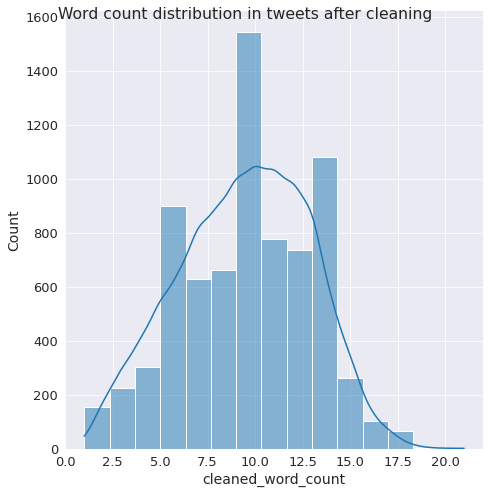

In [24]:
df_train["cleaned_word_count"] = df_train["cleaned_text"].apply(lambda x: len(x.split()))
ax = sns.displot(df_train["cleaned_word_count"],bins=15,kde=True, height=7)
ax.fig.suptitle('Word count distribution in tweets after cleaning')
plt.show()

In [25]:
df_train.sample(10)

,keyword,text,target,word_count,cleaned_text,cleaned_word_count
5429,police,#BREAKING411 4 police officers arrested for ab...,1,20,breaking police officer arrested abusing child...,14
2218,deluge,@TheGhostParty I am@so@sorry for the deluge of...,0,9,theghostparty sorry deluge hell vine,5
1877,crush,@jaureguiswisdom lmao well i only know one and...,0,17,jaureguiswisdom lmao well know one ive crush o...,9
3321,evacuate,I just want everyone to know that Emilee was w...,1,21,want everyone know emilee worried getting milk...,9
5592,razed,@petereallen @HuffPostUK @bbc5live How signifi...,0,20,petereallen huffpostuk bbclive significant thi...,14
6865,trauma,I need to plan a trip to Cleveland soon! ??,0,10,need plan trip cleveland soon,5
2524,desolation,In times of desolation and trouble Daniel's pe...,0,19,time desolation trouble daniel persistent pray...,13
1822,crashed,My iPod crashed..... \n#WeLoveYouLouis \n#MTVH...,1,7,ipod crashed weloveyoulouis mtvhottest one dir...,6
5636,refugees,#Turkish couple decided to feed 4000 #Syrian #...,0,16,turkish couple decided feed syrian refugee par...,11
463,attack,Just had a heart attack because I thought my g...,0,19,heart attack thought goat dead dont worry rock...,9


### Text vectorization & Word embedding
We'll use the `texts_to_sequences` method from the Keras Tokenizer class to convert text into sequences of integers. Specifically, this method maps each word in the text to a unique integer and returns a list of sequences, where each sequence represents the original text as a sequence of integers. The resulting sequences will be used as inputs for our neural network model that includes an **embedding** lalyer. The **embedding** layer learns to map each integer in the sequence to a dense vector of real numbers, effectively performing **word embedding** as part of the model training process. Therefore, we'll not perform **word embedding** at this step, but there are several popular techniques can be considered:
- Word2Vec: The approach involves training a shallow neural network on a large corpus of text data to predict the probability of a word given its context, or vice versa. The word embeddings are then obtained by extracting the weights of the hidden layer of the network.
- GloVe: The approach uses a co-occurrence matrix to capture the statistical relationships between words in a corpus. The word embeddings are obtained by performing singular value decomposition (SVD) on the co-occurrence matrix and extracting the resulting word vectors.

In [26]:
# only keep the top 3000 most frequent words in the corpus
max_features=3000 
tokenizer=Tokenizer(num_words=max_features,split=' ')

# convert the text data into sequences of integers
tokenizer.fit_on_texts(df_train['cleaned_text'].values)
X = tokenizer.texts_to_sequences(df_train['cleaned_text'].values)

# pad the sequences of integers with zeros so that they are all of the same length
X = pad_sequences(X)

# sets the target variable to the values in the target
y = df_train['target']

Next we'll split the training data into training and validation sets. 

In [27]:
X_train, X_validation, y_train, y_validation = train_test_split(X,y, test_size = 0.2, random_state =2023)

In [28]:
X_train.shape, y_train.shape, X_validation.shape, y_validation.shape

((5957, 18), (5957,), (1490, 18), (1490,))

Now we are ready to build some deep learning models!!

## Model Architecture

### LSTM Model
LSTM (Long Short-Term Memory) is a type of recurrent neural network (RNN) architecture that is commonly used in deep learning for sequence modeling tasks, such as text classification. One of the main advantages of LSTM for text classification is its ability to capture long-term dependencies in the input text. This is important for our task that the meaning of a text may depend on the context of previous words or sentences.

In an LSTM model, the memory cell is composed of a set of gates that control the flow of information into and out of the cell. The gates are implemented as sigmoid neural networks that output values between 0 and 1, indicating the degree to which certain information should be retained or forgotten. These are the layers that will be added into the model:

- **Embedding layer** converts the input integer into corresponding word vectors. Here we'll use Embedding in Keras to represent words as vectors. Similar vectors indicate the words have similar meaning.
- **LSTM layer** learn long-term dependencies between time steps in sequence data.
- **Dropout layers** randomly sets inputs as 0 during training to reduce overfitting.
- **Dense layers** takes the input from all the other neurons of the previous layer. Since we're solving a binary classification problem (disaster or non disaster), we'll use Dense layer as the output layer. 

In [29]:
model_1 = Sequential()
model_1.add(Embedding(max_features, 32,input_length = X.shape[1]))
model_1.add(Dropout(0.2))
model_1.add(LSTM(128, return_sequences=True))
model_1.add(Dense(1,activation='sigmoid'))
adam = optimizers.Adam(learning_rate=0.001)
model_1.compile(loss = 'binary_crossentropy', optimizer=adam ,metrics = ['accuracy'])
model_1.summary()

2023-02-15 06:03:44.068464: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 18, 32)            96000     
_________________________________________________________________
dropout (Dropout)            (None, 18, 32)            0         
_________________________________________________________________
lstm (LSTM)                  (None, 18, 128)           82432     
_________________________________________________________________
dense (Dense)                (None, 18, 1)             129       
Total params: 178,561
Trainable params: 178,561
Non-trainable params: 0
_________________________________________________________________


## Results and Analysis

In [30]:
callbacks = [ ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_accuracy', min_delta=1e-4, patience=5)]

history_1 = model_1.fit(X_train, y_train, epochs = 20, batch_size=32, 
                        validation_data=(X_validation, y_validation), callbacks= [callbacks])

Epoch 1/20


2023-02-15 06:03:44.432524: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


187/187 [==============================] - 9s 31ms/step - loss: 0.6611 - accuracy: 0.6134 - val_loss: 0.6150 - val_accuracy: 0.6544
Epoch 2/20
187/187 [==============================] - 5s 26ms/step - loss: 0.5943 - accuracy: 0.6713 - val_loss: 0.6062 - val_accuracy: 0.6599
Epoch 3/20
187/187 [==============================] - 5s 26ms/step - loss: 0.5716 - accuracy: 0.6804 - val_loss: 0.6104 - val_accuracy: 0.6588
Epoch 4/20
187/187 [==============================] - 5s 27ms/step - loss: 0.5593 - accuracy: 0.6867 - val_loss: 0.6192 - val_accuracy: 0.6568
Epoch 5/20
187/187 [==============================] - 5s 26ms/step - loss: 0.5507 - accuracy: 0.6903 - val_loss: 0.6234 - val_accuracy: 0.6540
Epoch 6/20
187/187 [==============================] - 5s 26ms/step - loss: 0.5452 - accuracy: 0.6933 - val_loss: 0.6331 - val_accuracy: 0.6554
Epoch 7/20
187/187 [==============================] - 5s 26ms/step - loss: 0.5398 - accuracy: 0.6956 - val_loss: 0.6439 - val_accuracy: 0.6545


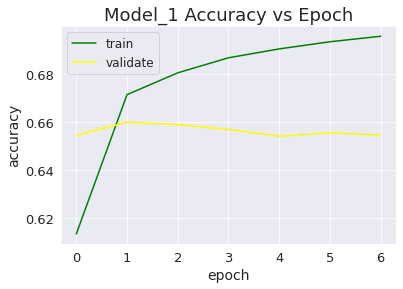

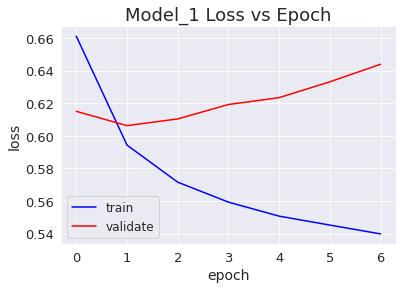

In [31]:
# model_1 accuracy vs epoch
plt.plot(history_1.history['accuracy'], color='green')
plt.plot(history_1.history['val_accuracy'], color='yellow')
plt.title('Model_1 Accuracy vs Epoch')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='upper left')
plt.show()

# model_1 loss vs epoch
plt.plot(history_1.history['loss'], color='blue')
plt.plot(history_1.history['val_loss'], color='red')
plt.title('Model_1 Loss vs Epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='lower left')
plt.show()

### Hyperparameter tuning
For our first model, the accuracy is ~ 0.7 for the training set and ~ 0.65 for the validation set. We'll try to improve it by tuning some hyperparameters. 
- **LSTM and Number of LSTM units:** we'll add another LSTM layer and increase the number of units from 128 to 256. This will increase the model's ability to capture complex pattern in the tweets.
- **Learning rate:** we'll change it from 0.001 to 0.0001. This may lead to better generalization, the convergence is likely slower though.
- **Dropout and Dropout rate:** we'll add two more dropout layers and increase the rate from 0.2 to 0.5, dropping out more 'neurons' during training to reduce overfitting.

In [32]:
model_2 = Sequential()
model_2.add(Embedding(max_features, 32,input_length = X.shape[1]))
model_2.add(Dropout(0.5))
model_2.add(LSTM(256, return_sequences=True))
model_2.add(Dropout(0.5))
model_2.add(LSTM(256))
model_2.add(Dropout(0.5))
model_2.add(Dense(1,activation='sigmoid'))
adam = optimizers.Adam(learning_rate=0.0001)
model_2.compile(loss = 'binary_crossentropy', optimizer=adam ,metrics = ['accuracy'])
model_2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 18, 32)            96000     
_________________________________________________________________
dropout_1 (Dropout)          (None, 18, 32)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 18, 256)           295936    
_________________________________________________________________
dropout_2 (Dropout)          (None, 18, 256)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 256)               525312    
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                

In [33]:
callbacks = [ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_accuracy', min_delta=1e-4, patience=5)]
%timeit
history_2 = model_2.fit(X_train, y_train, epochs = 20, batch_size=32, 
                        validation_data=(X_validation, y_validation), callbacks= [callbacks])

Epoch 1/20
187/187 [==============================] - 22s 96ms/step - loss: 0.6796 - accuracy: 0.5731 - val_loss: 0.6713 - val_accuracy: 0.5732
Epoch 2/20
187/187 [==============================] - 18s 96ms/step - loss: 0.6594 - accuracy: 0.6099 - val_loss: 0.6305 - val_accuracy: 0.6651
Epoch 3/20
187/187 [==============================] - 18s 96ms/step - loss: 0.5777 - accuracy: 0.7103 - val_loss: 0.5247 - val_accuracy: 0.7416
Epoch 4/20
187/187 [==============================] - 17s 92ms/step - loss: 0.4692 - accuracy: 0.7846 - val_loss: 0.4771 - val_accuracy: 0.7779
Epoch 5/20
187/187 [==============================] - 18s 97ms/step - loss: 0.4224 - accuracy: 0.8093 - val_loss: 0.4673 - val_accuracy: 0.7779
Epoch 6/20
187/187 [==============================] - 17s 91ms/step - loss: 0.3942 - accuracy: 0.8298 - val_loss: 0.4591 - val_accuracy: 0.7859
Epoch 7/20
187/187 [==============================] - 18s 95ms/step - loss: 0.3801 - accuracy: 0.8350 - val_loss: 0.4581 - val_accuracy:

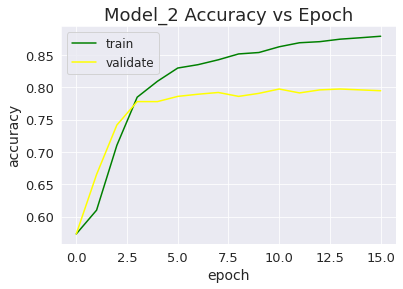

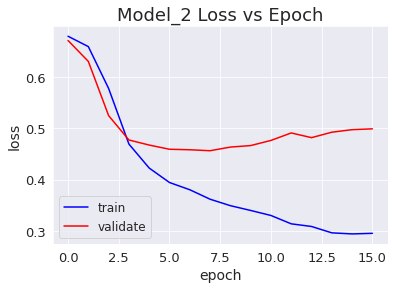

In [34]:
# model_2 accuracy vs epoch
plt.plot(history_2.history['accuracy'], color='green')
plt.plot(history_2.history['val_accuracy'], color='yellow')
plt.title('Model_2 Accuracy vs Epoch')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='upper left')
plt.show()

# model_2 loss vs epoch
plt.plot(history_2.history['loss'], color='blue')
plt.plot(history_2.history['val_loss'], color='red')
plt.title('Model_2 Loss vs Epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='lower left')
plt.show()

After tuning the hyperparameters, the accuracy is increased from 0.7 to 0.88 for training set and from 0.65 to 0.8 for validation set. During this process, I also tried to increase the batch size, but it didn't change the accuracy much. This makes sense as the batch size determines the number of samples used to update the model weights during training. Ultimately, I didn't change the batch size in the model, as larger batch size results in faster convergence, but requires more memory.

Next, let's try another type of recurrent neural network (RNN) model, Gated Recurrent Unit (GRU).

### GRU Model
GRU layer has a similar structure to the LSTM layer, but with fewer parameters, which may result in faster training and better generalization. GRUs use two gates: a reset gate and an update gate, which are used to control the flow of information in and out of the hidden state of the network. The reset gate determines how much of the previous hidden state should be forgotten, while the update gate determines how much of the new input should be added to the hidden state.

To compare between LSTM and GRU, we'll simply replace the LSTM layers with GRU, keeping other parameters the same.

In [35]:
model_3 = Sequential()
model_3.add(Embedding(max_features, 32, input_length=X.shape[1]))
model_3.add(Dropout(0.5))
model_3.add(GRU(256, return_sequences=True))
model_3.add(Dropout(0.5))
model_3.add(GRU(256))
model_3.add(Dropout(0.5))
model_3.add(Dense(1, activation='sigmoid'))
adam = optimizers.Adam(learning_rate=0.0001)
model_3.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
model_3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 18, 32)            96000     
_________________________________________________________________
dropout_4 (Dropout)          (None, 18, 32)            0         
_________________________________________________________________
gru (GRU)                    (None, 18, 256)           222720    
_________________________________________________________________
dropout_5 (Dropout)          (None, 18, 256)           0         
_________________________________________________________________
gru_1 (GRU)                  (None, 256)               394752    
_________________________________________________________________
dropout_6 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                

In [36]:
callbacks = [ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_accuracy', min_delta=1e-4, patience=5)]

history_3 = model_3.fit(X_train, y_train, epochs = 20, batch_size=32, 
                        validation_data=(X_validation, y_validation), callbacks= [callbacks])

Epoch 1/20
187/187 [==============================] - 22s 95ms/step - loss: 0.6725 - accuracy: 0.5785 - val_loss: 0.6557 - val_accuracy: 0.6342
Epoch 2/20
187/187 [==============================] - 16s 87ms/step - loss: 0.6262 - accuracy: 0.6644 - val_loss: 0.5872 - val_accuracy: 0.7195
Epoch 3/20
187/187 [==============================] - 17s 92ms/step - loss: 0.5004 - accuracy: 0.7678 - val_loss: 0.4840 - val_accuracy: 0.7785
Epoch 4/20
187/187 [==============================] - 16s 86ms/step - loss: 0.4319 - accuracy: 0.8019 - val_loss: 0.4693 - val_accuracy: 0.7906
Epoch 5/20
187/187 [==============================] - 17s 91ms/step - loss: 0.3939 - accuracy: 0.8258 - val_loss: 0.4631 - val_accuracy: 0.7913
Epoch 6/20
187/187 [==============================] - 16s 87ms/step - loss: 0.3784 - accuracy: 0.8367 - val_loss: 0.4652 - val_accuracy: 0.8013
Epoch 7/20
187/187 [==============================] - 17s 91ms/step - loss: 0.3608 - accuracy: 0.8427 - val_loss: 0.4665 - val_accuracy:

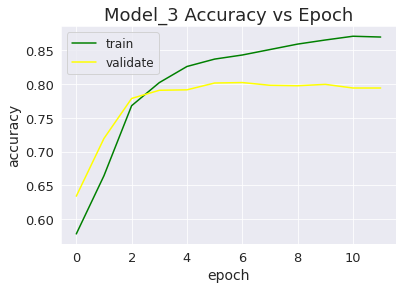

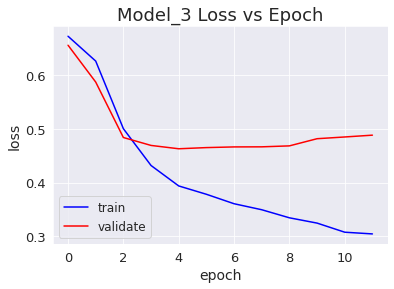

In [37]:
# model_3 accuracy vs epoch
plt.plot(history_3.history['accuracy'], color='green')
plt.plot(history_3.history['val_accuracy'], color='yellow')
plt.title('Model_3 Accuracy vs Epoch')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='upper left')
plt.show()

# model_3 loss vs epoch
plt.plot(history_3.history['loss'], color='blue')
plt.plot(history_3.history['val_loss'], color='red')
plt.title('Model_3 Loss vs Epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='lower left')
plt.show()

We can see that the performance of GRU is nearly as good as LSTM, but it is much faster. Since LSTM is a little better, we'll use LSTM model (model_2) for prediction. 

## Prediction & Submission
This is the format that we need to follow for submission.

In [38]:
df_submission.head()

,id,target
0,0,0
1,2,0
2,3,0
3,9,0
4,11,0


Below is the provided test set. 
- We'll perform the same data preprocessing for test set as we did for the training set
- We'll use model_2 trained above to predict

In [39]:
df_test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [40]:
df_test = df_test.drop(columns=['keyword', 'location'])
df_test.head()

,id,text
0,0,Just happened a terrible car crash
1,2,"Heard about #earthquake is different cities, s..."
2,3,"there is a forest fire at spot pond, geese are..."
3,9,Apocalypse lighting. #Spokane #wildfires
4,11,Typhoon Soudelor kills 28 in China and Taiwan


In [41]:
df_test['cleaned_text'] = df_test['text'].apply(data_cleaning)
df_test.sample(10)

,id,text,cleaned_text
2036,6846,JohnMtaita: Breaking news! Unconfirmed! I just...,johnmtaita breaking news unconfirmed heard lou...
1722,5810,Something to think about,something think
1947,6564,@_keypsters full game? Injury cut is here http...,_keypsters full game injury cut httpstcoyyqwssoj
2283,7625,Pandemonium In Aba As Woman Delivers Baby With...,pandemonium aba woman delivers baby without fa...
585,1903,fear the fever Can you feel it now? I feel the...,fear fever feel feel fire burning beloooow gon...
1160,3818,@NickKristof Contradictory: 'We should've trie...,nickkristof contradictory shouldve tried deton...
112,374,RT SIGN URGENT Stop the Annihilation of the Sa...,sign urgent stop annihilation salt river wild ...
327,1060,Yeah I hate cats I just tried to pet our own c...,yeah hate cat tried pet cat hand bite mark scr...
2499,8331,China's Stock Market Crash: Are There Gems In ...,china stock market crash gem rubble httptcoqen...
1544,5158,11-Year-Old Boy Charged With Manslaughter of T...,yearold boy charged manslaughter toddler repor...


In [42]:
test_tokenizer=Tokenizer(num_words=max_features,split=' ')

# convert the text data into sequences of integers
test_tokenizer.fit_on_texts(df_test['cleaned_text'].values)
test_X = test_tokenizer.texts_to_sequences(df_test['cleaned_text'].values)

# pad the sequences of integers with zeros so that they are all of the same length
test_X = pad_sequences(test_X)

In [43]:
predictions = model_2.predict(test_X)
predictions = [0 if prediction < 0.5 else 1 for prediction in predictions]
predictions[:10]

[1, 1, 0, 0, 0, 0, 0, 0, 0, 0]

In [44]:
df_test['target'] = predictions

In [45]:
df_test.head()

,id,text,cleaned_text,target
0,0,Just happened a terrible car crash,happened terrible car crash,1
1,2,"Heard about #earthquake is different cities, s...",heard earthquake different city stay safe ever...,1
2,3,"there is a forest fire at spot pond, geese are...",forest fire spot pond goose fleeing across str...,0
3,9,Apocalypse lighting. #Spokane #wildfires,apocalypse lighting spokane wildfire,0
4,11,Typhoon Soudelor kills 28 in China and Taiwan,typhoon soudelor kill china taiwan,0


### Submission

In [46]:
df_test[["id", "target"]].to_csv("submission.csv", index=False)

## Conclusion
- After hyperparameter tuning, the accuracy is greatly increased. Techniques like early stopping were used to reduce overfitting and the time required for training. I've tried different combinations - sometimes the accuracy for training is higher than 0.9 but I was not able to further increase the accuracy for validation. 
- To further improve the model, a grid search or a random search over a range of hyperparameters might be considered to find the best combination. 
- One takeaway from this mini-project is to keep in mind the trade-off between model capacity and overfitting, as well as the computational resources required. 
- The choice between LSTM and GRU depends on the specific task and the characteristics of the dataset. In the current case, it seems that the two architectures can be used interchangeably, and it may be worth trying both to see which one works best for other tasks.

## Reference
- https://alvinntnu.github.io/NTNU_ENC2045_LECTURES/nlp/dl-simple-case.html
- https://github.com/karansangha/dtsa5511-week4-nlp/blob/main/project.ipynb
- https://github.com/cloud-erik/5511/blob/main/Disaster_Tweets.ipynb
- https://github.com/clebastard21/DTSA-5511-NLP-with-Disaster-Tweets/blob/main/DTSA%205511%20-%20Week%204.ipynb